In [363]:
#https://www.kaggle.com/pmarcelino/comprehensive-data-exploration-with-python

In [364]:
import pandas as pd
import numpy as np

#Visualization
import plotly.express as px
import matplotlib.pyplot as plt

# Basic
import re
import math


# metrics
from sklearn.metrics import mean_squared_error

In [365]:
# Configurations

pd.set_option('display.max_rows',None)
pd.set_option('display.max_columns',None)

In [366]:
df_train = pd.read_csv('data/train.csv')
df_test = pd.read_csv('data/test.csv')
print("train -> ",df_train.shape, "\ntest  -> ",df_test.shape)

train ->  (1460, 81) 
test  ->  (1459, 80)


In [367]:
set(df_train.columns) - set(df_test.columns)

{'SalePrice'}

## Sales Price

In [368]:
df_train['SalePrice'].describe()

count      1460.000000
mean     180921.195890
std       79442.502883
min       34900.000000
25%      129975.000000
50%      163000.000000
75%      214000.000000
max      755000.000000
Name: SalePrice, dtype: float64

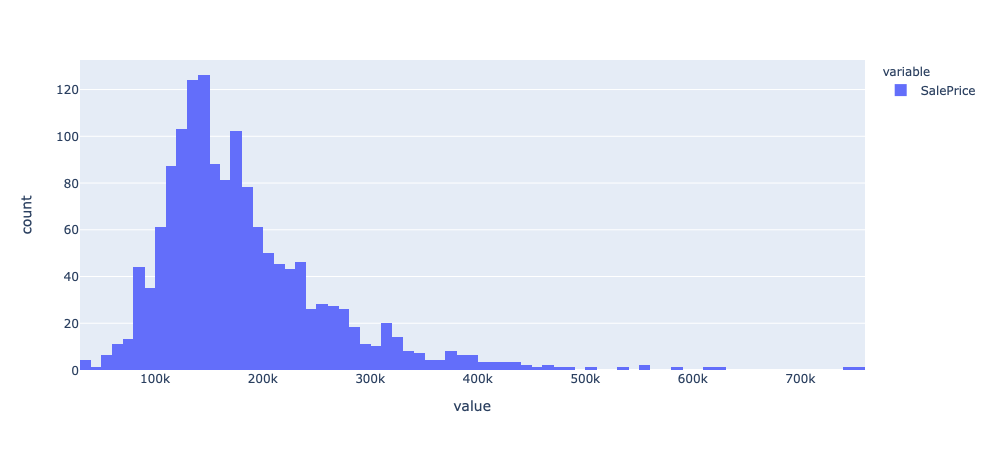

In [369]:
px.histogram(df_train['SalePrice'],nbins=100)

Right skewed

In [370]:
df_train['SalePrice'].skew()
#df_train['SalePrice'].kurt()

1.8828757597682129

### Changing to appropriate datatypes

In [371]:
# Lets combine both training and testing datasets together
df_test['SalePrice'] =np.nan
df_combined = pd.concat([df_train,df_test])

In [372]:
# MSSubClass,MoSold to ste
# GarageYrBlt, GarageArea to int
df_combined[['MSSubClass','MoSold']] = df_combined[['MSSubClass','MoSold']].astype(str)
df_combined[['GarageYrBlt','GarageArea','GarageCars']] = df_combined[['GarageYrBlt','GarageArea']].apply(pd.to_numeric)

ValueError: Columns must be same length as key

### Missing Data

In [373]:
train_nrows = df_train.shape[0]
missing_count = df_train.isnull().sum().sort_values(ascending=False)
missing_percent = df_train.isnull().sum()/train_nrows
missing_data = pd.concat([missing_count,missing_percent],axis=1).rename(columns={0:'missing_count',1:'missing_percent'})
missing_data[missing_data['missing_count']>0]

,missing_count,missing_percent
PoolQC,1453,0.995205
MiscFeature,1406,0.963014
Alley,1369,0.937671
Fence,1179,0.807534
FireplaceQu,690,0.472603
LotFrontage,259,0.177397
GarageYrBlt,81,0.055479
GarageCond,81,0.055479
GarageType,81,0.055479
GarageFinish,81,0.055479


## Pool Variables

In [374]:
reg = re.compile(".*pool.*",re.IGNORECASE)
pool_columns = list(filter(reg.match,list(df_combined.columns)))
print("Pool related variables are : ",pool_columns)
df_combined.groupby('PoolQC',dropna=False).agg({'PoolArea':['sum',np.median,'count']})

Pool related variables are :  ['PoolArea', 'PoolQC']


PoolArea             
            sum median count
PoolQC                      
Ex         1439  370.0     4
Fa         1167  583.5     2
Gd         2594  657.0     4
NaN        1373    0.0  2909

Missing values in Pool Quality (PoolQC) corresponds to houses with no pools, it makes sense that not many house will have pools attached to it. So we can fill the missing value as "NA"

In [375]:
df_combined['PoolQC'].fillna("NA",inplace=True)

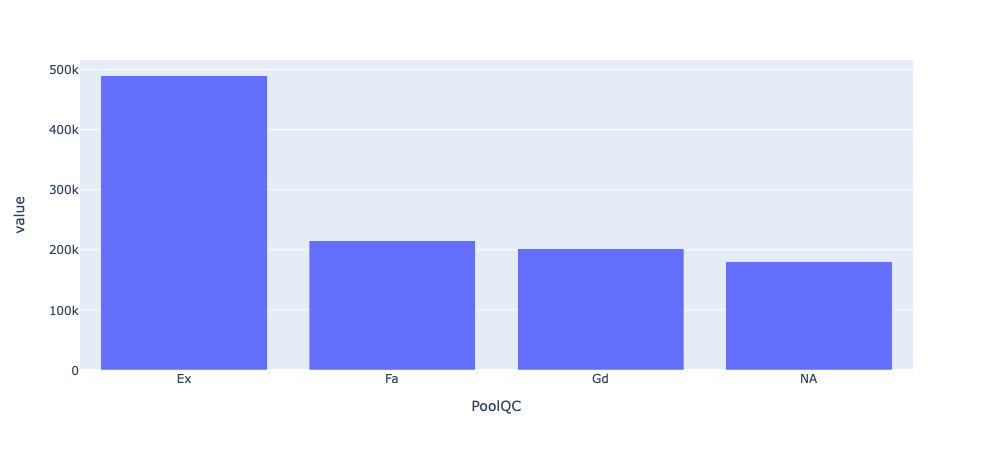

In [376]:
fig = px.bar(df_combined.groupby('PoolQC',dropna=False).agg({'SalePrice':'mean'}))
fig.update_layout(showlegend=False).show()

## MiscFeature Valriables

#### Definition
MiscFeature: Miscellaneous feature not covered in other categories

MiscVal: $Value of miscellaneous feature

In [377]:
reg = re.compile(".*Misc.*",re.IGNORECASE)
Misc_columns = list(filter(reg.match,list(df_combined.columns)))
print("Miscellaneous variables are  : ",Misc_columns)
df_combined[Misc_columns].groupby('MiscFeature',dropna=False).agg({'MiscVal':['sum','count']})

Miscellaneous variables are  :  ['MiscFeature', 'MiscVal']


MiscVal      
                sum count
MiscFeature              
Gar2          43800     5
Othr          13000     4
Shed          72561    95
TenC           2000     1
NaN           17000  2814

In [378]:
df_combined[df_combined['MiscFeature'].isnull()]['MiscVal'].value_counts()

0        2813
17000       1
Name: MiscVal, dtype: int64

In [379]:
# Impute this MiscFeature for this record (which has MiscValue) to 'Othr'
df_combined.loc[(df_combined['MiscFeature'].isnull()) & (df_combined['MiscVal']>0),'MiscFeature'] = 'Othr'

# Impute other records to 'NA', this means there is no misc features in this house
df_combined['MiscFeature'].fillna("NA",inplace=True)

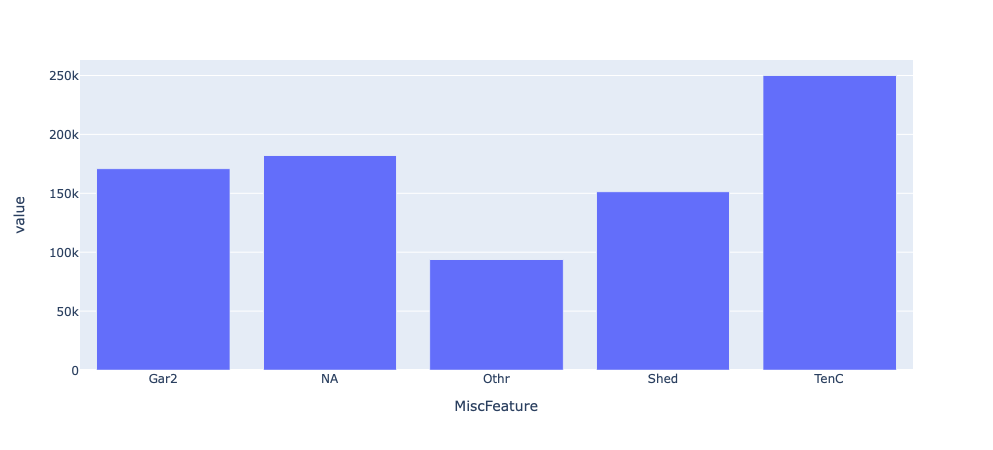

In [380]:
fig = px.bar(df_combined.groupby('MiscFeature',dropna=False).agg({'SalePrice':'mean'}))
fig.update_layout(showlegend=False).show()

## Alley Variables

In [381]:
reg = re.compile(".*Alley.*",re.IGNORECASE)
alley_columns = list(filter(reg.match,list(df_combined.columns)))
print("Alley variables are  : ",alley_columns)

Alley variables are  :  ['Alley']


In [382]:
df_combined['Alley'].value_counts(dropna=False)

NaN     2721
Grvl     120
Pave      78
Name: Alley, dtype: int64

In [383]:
# Lets assume Missing data means no alley access to the house
df_combined['Alley'].fillna("NA",inplace=True)

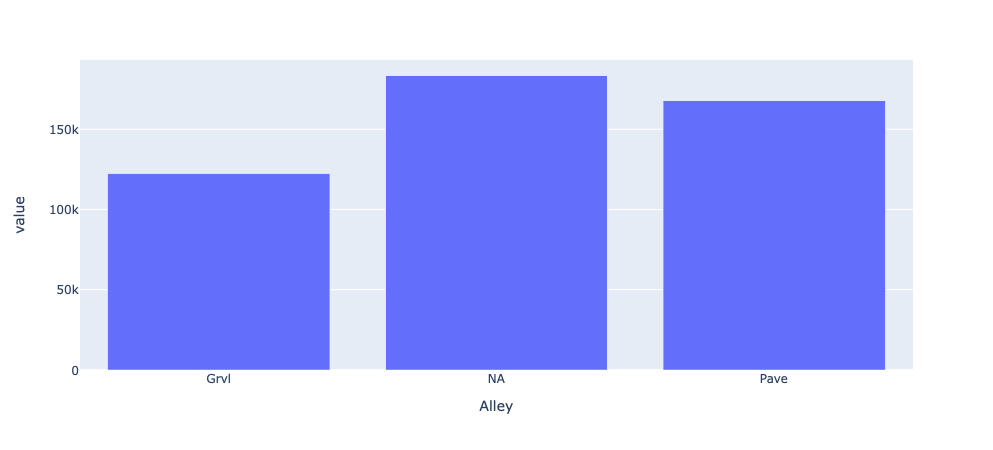

In [384]:
fig = px.bar(df_combined.groupby('Alley',dropna=False).agg({'SalePrice':'mean'}))
fig.update_layout(showlegend=False).show()

## Fence Variables

In [385]:
reg = re.compile(".*Fence.*",re.IGNORECASE)
alley_columns = list(filter(reg.match,list(df_combined.columns)))
print("Fence variables are  : ",alley_columns)

Fence variables are  :  ['Fence']


In [386]:
df_combined['Fence'].value_counts(dropna=False)

NaN      2348
MnPrv     329
GdPrv     118
GdWo      112
MnWw       12
Name: Fence, dtype: int64

In [387]:
# Lets assume Missing data means no Fence to the house
df_combined['Fence'].fillna("NA",inplace=True)

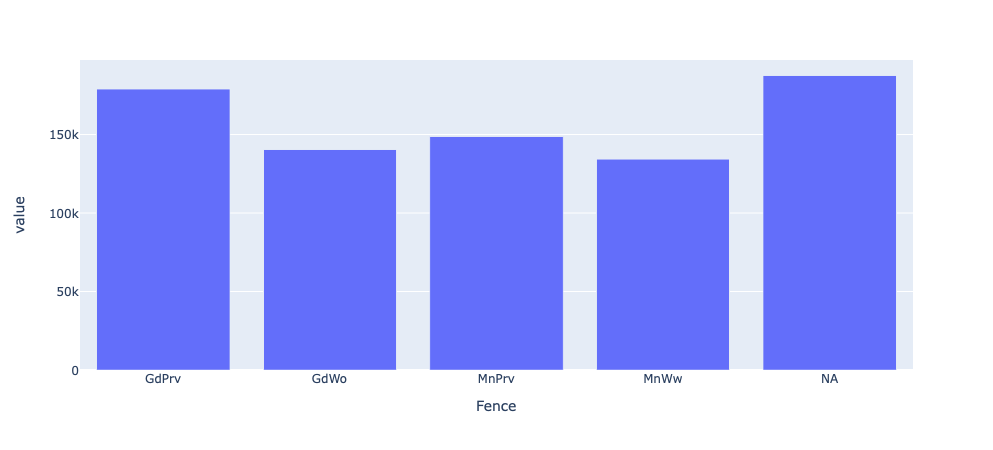

In [388]:
fig = px.bar(df_combined.groupby('Fence',dropna=False).agg({'SalePrice':'mean'}))
fig.update_layout(showlegend=False).show()

## Fire Place Variables

In [389]:
reg = re.compile(".*Fire.*",re.IGNORECASE)
fire_columns = list(filter(reg.match,list(df_combined.columns)))
print("Fire Place variables are  : ",alley_columns)

Fire Place variables are  :  ['Fence']


In [390]:
df_combined.groupby(['Fireplaces','FireplaceQu'],dropna=False).size().reset_index()

,Fireplaces,FireplaceQu,0
0,0,NaN,1420
1,1,Ex,37
2,1,Fa,63
3,1,Gd,627
4,1,Po,46
5,1,TA,495
6,2,Ex,5
7,2,Fa,10
8,2,Gd,112
9,2,TA,92


In [391]:
# Here Missing FireplaceQu meaning Fireplace is not available.

df_combined['FireplaceQu'].fillna("Na",inplace=True)

## Lot variable

In [392]:
reg = re.compile(".*Lot.*",re.IGNORECASE)
lot_columns = list(filter(reg.match,list(df_combined.columns)))
print("Lot variables are  : ",lot_columns)

Lot variables are  :  ['LotFrontage', 'LotArea', 'LotShape', 'LotConfig']


In [393]:
# Assume missing value in LotFrontage meant, house does not have front lot
df_combined['LotFrontage'].fillna(0.0,inplace=True)

## Garage Variable

In [394]:
reg = re.compile(".*garage.*",re.IGNORECASE)
garage_columns = list(filter(reg.match,list(df_combined.columns)))
print("Lot variables are  : ",garage_columns)

Lot variables are  :  ['GarageType', 'GarageYrBlt', 'GarageFinish', 'GarageCars', 'GarageArea', 'GarageQual', 'GarageCond']


In [395]:
df_combined['GarageCars'].value_counts()

2.0    1594
1.0     776
3.0     374
0.0     157
4.0      16
5.0       1
Name: GarageCars, dtype: int64

In [396]:
# Missing Values in Garage columns corresponds to zero Garagearea which implies these houses does not have Garage
garage_cat_cols = ['GarageType','GarageFinish','GarageQual','GarageCond']
df_combined[garage_cat_cols] = df_combined[garage_cat_cols].fillna("NA")

garage_num_cols = ['GarageYrBlt','GarageCars','GarageArea']
df_combined[garage_num_cols] = df_combined[garage_num_cols].fillna(df_combined[garage_num_cols].median())

## BsmtFinType2

BsmtQual: Height of the basement  
BsmtCond: General condition of the basement  
BsmtExposure: Walkout or garden level basement walls  
BsmtFinType1: Quality of basement finished area  
BsmtFinSF1: Type 1 finished square feet  
BsmtFinType2: Quality of second finished area (if present)  
BsmtFinSF2: Type 2 finished square feet  
BsmtUnfSF: Unfinished square feet of basement area  
TotalBsmtSF: Total square feet of basement area  

In [397]:
reg = re.compile(".*Bsmt.*",re.IGNORECASE)
bsmt_columns = list(filter(reg.match,list(df_combined.columns)))
print("Basement COlumns are : ", bsmt_columns)

Basement COlumns are :  ['BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinSF1', 'BsmtFinType2', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'BsmtFullBath', 'BsmtHalfBath']


In [398]:
# Missing value represents , absence of basement
col = ['BsmtFinType2','BsmtExposure','BsmtQual','BsmtCond']
df_combined[col] = df_combined[col].fillna("NA")

## Masonry veneer

MasVnrType: Masonry veneer type  
MasVnrArea: Masonry veneer area in square feetm

In [399]:
reg = re.compile(".*MasVnr.*",re.IGNORECASE)
masvnr_columns = list(filter(reg.match,list(df_combined.columns)))
print("Masonry veneer variables are  : ",masvnr_columns)

Masonry veneer variables are  :  ['MasVnrType', 'MasVnrArea']


In [400]:
df_combined.loc[df_combined['MasVnrArea']>0,masvnr_columns].groupby('MasVnrType',dropna=False).agg({'MasVnrArea':['sum','mean',np.median,'count']})

MasVnrArea                         
                  sum        mean median count
MasVnrType                                    
BrkCmn         4887.0  195.480000  161.0    25
BrkFace      230010.0  262.269099  203.0   877
None           1232.0  176.000000  285.0     7
Stone         59648.0  240.516129  200.0   248
NaN             198.0  198.000000  198.0     1

In [401]:
df_combined.loc[((df_combined['MasVnrType']=='None') & (df_combined['MasVnrArea']==1)) ,'MasVnrArea'] =0.0

In [402]:
# Impute with most common value
df_combined.loc[((df_combined['MasVnrType']=='None') & (df_combined['MasVnrArea']>0)) ,'MasVnrType'] = 'BrkFace'
df_combined.loc[((df_combined['MasVnrType'].isnull()) & (df_combined['MasVnrArea']>0)) ,'MasVnrType'] = 'BrkFace'

In [403]:
df_combined['MasVnrType'] = df_combined['MasVnrType'].fillna('None')
df_combined['MasVnrArea'] = df_combined['MasVnrArea'].fillna(0)

## Electrical

In [404]:
df_combined['Electrical'].value_counts(dropna=False)

SBrkr    2671
FuseA     188
FuseF      50
FuseP       8
NaN         1
Mix         1
Name: Electrical, dtype: int64

In [405]:
# Impute with most common value
df_combined.loc[df_combined['Electrical'].isnull(),'Electrical'] = 'SBrKr'

In [406]:
train = df_combined[:train_nrows]
test = df_combined[train_nrows:].drop('SalePrice',axis = 1)

In [407]:
train.shape,test.shape

((1460, 81), (1459, 80))

### Encoding Cat Variable

In [408]:
train = pd.get_dummies(train)
test = pd.get_dummies(test)

## Modeling

In [409]:
from sklearn.model_selection import train_test_split



In [410]:
train_X , valid_X, train_y, valid_y = train_test_split(train.drop('SalePrice',axis = 1),train['SalePrice'],
                                                       test_size = 0.3)

### Decision Tree Regressor

In [358]:
from sklearn.tree import DecisionTreeRegressor

In [413]:
model = DecisionTreeRegressor(max_depth=5)
model.fit(train_X,train_y)

DecisionTreeRegressor(max_depth=5)

In [414]:
# model.predict(train_X)
math.sqrt(mean_squared_error(model.predict(train_X),train_y))

28352.683818934365

[Text(196.94117647058826, 199.32, 'X[3] <= 7.5\nmse = 6055917435.891\nsamples = 1022\nvalue = 180754.86'),
 Text(105.03529411764707, 163.07999999999998, 'X[3] <= 6.5\nmse = 2527353520.382\nsamples = 866\nvalue = 158499.05'),
 Text(52.517647058823535, 126.83999999999999, 'X[15] <= 1378.5\nmse = 1404771605.977\nsamples = 636\nvalue = 140010.709'),
 Text(26.258823529411767, 90.6, 'X[11] <= 1007.5\nmse = 816195140.247\nsamples = 399\nvalue = 124520.195'),
 Text(13.129411764705884, 54.359999999999985, 'X[3] <= 4.5\nmse = 637729268.483\nsamples = 271\nvalue = 114482.734'),
 Text(6.564705882352942, 18.119999999999976, 'mse = 521989372.002\nsamples = 76\nvalue = 92313.605'),
 Text(19.694117647058825, 18.119999999999976, 'mse = 416636390.554\nsamples = 195\nvalue = 123123.01'),
 Text(39.38823529411765, 54.359999999999985, 'X[24] <= 1979.5\nmse = 529119922.846\nsamples = 128\nvalue = 145771.383'),
 Text(32.82352941176471, 18.119999999999976, 'mse = 410773462.469\nsamples = 102\nvalue = 139741.22

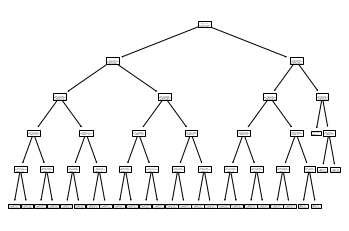

In [415]:
from sklearn import tree
tree.plot_tree(model)